In [1]:
# CELL 1
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, jaccard_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


In [2]:
# CELL 2
# Define variables
img_height = 512
img_width = 128
channels = 3
num_classes = 4

batch_size = 4   # Increased batch size for stability
epochs = 20     # Increased epochs for better training

# Paths to the datasets
image_dir = r"/kaggle/input/whole-body-bone-scan-with-mask/ANT WBBS 3 Class/Whole Body Bone Scan ANT"
mask_dir = r"/kaggle/input/whole-body-bone-scan-with-mask/ANT WBBS 3 Class/MaskV3"

# Directory to save model checkpoints
checkpoint_dir = r"/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)


In [3]:
# CELL 3
# Updated for 4 classes
num_classes = 4  # Change back from 3 to 4

# Initialize lists to hold images and masks
images = []
masks = []

# Get list of image files
image_files = [
    f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')
]

# Load images and corresponding masks
for file in image_files:
    # Load and resize image
    image_path = os.path.join(image_dir, file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {file}, skipping.")
        continue
    # Resize image: cv2.resize expects (width, height)
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0  # Normalize image

    # Construct mask filename
    base_filename = os.path.splitext(file)[0]
    mask_filename = base_filename + '_colored_mask.npy'  # Adjust based on your mask filename pattern
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {file}, skipping.")
        continue

    # Load and resize mask
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

    # Check unique values in mask (0, 1, 2, 3)
    unique_values = np.unique(mask)
    print(f"Unique values in {mask_filename}: {unique_values}")
    if not np.all(np.isin(unique_values, [0, 1, 2, 3])):
        print(f"Unexpected values in mask for {file}, skipping.")
        continue

    # Convert mask to one-hot encoding
    mask_one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.uint8)
    for i in range(num_classes):
        mask_one_hot[..., i] = (mask == i).astype(np.uint8)

    images.append(image)
    masks.append(mask_one_hot)

# Convert lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes
print("Images shape:", images.shape)  # Expected: (num_samples, img_height, img_width, channels)
print("Masks shape:", masks.shape)    # Expected: (num_samples, img_height, img_width, num_classes)


Unique values in 1269_colored_mask.npy: [0 1 2]
Unique values in 623_colored_mask.npy: [0 1]
Unique values in 2193_colored_mask.npy: [0 1]
Unique values in 2008_colored_mask.npy: [0 1]
Unique values in 2081_colored_mask.npy: [0 1 2]
Unique values in 3138_colored_mask.npy: [0 1 2]
Unique values in 764_colored_mask.npy: [0 1]
Unique values in 1700_colored_mask.npy: [0 1]
Unique values in 1786_colored_mask.npy: [0 1]
Unique values in 2907_colored_mask.npy: [0 1]
Unique values in 1075_colored_mask.npy: [0 1]
Unique values in 2863_colored_mask.npy: [0 1 2]
Unique values in 771_colored_mask.npy: [0 1]
Unique values in 208_colored_mask.npy: [0 1]
Unique values in 2628_colored_mask.npy: [0 1 2]
Unique values in 820_colored_mask.npy: [0 1]
Unique values in 1789_colored_mask.npy: [0 1]
Unique values in 473_colored_mask.npy: [0 1 2]
Unique values in 1792_colored_mask.npy: [0 1]
Unique values in 2936_colored_mask.npy: [0 1 2]
Unique values in 2029_colored_mask.npy: [0 1 2]
Unique values in 1411_co

In [4]:
# CELL 4

# Split data into training, validation, and test sets
X_temp, X_test, Y_temp, Y_test = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.2, random_state=42
)

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (2104, 512, 128, 3)
Y_train shape: (2104, 512, 128, 4)
X_val shape: (527, 512, 128, 3)
Y_val shape: (527, 512, 128, 4)
X_test shape: (293, 512, 128, 3)
Y_test shape: (293, 512, 128, 4)


In [5]:
# CELL 5
# WORKING CODE
from sklearn.utils import class_weight

# Flatten masks to compute class weights
all_masks_flat = np.argmax(Y_train, axis=-1).flatten()
unique_classes, counts = np.unique(all_masks_flat, return_counts=True)
class_distribution = dict(zip(unique_classes, counts))
print("Class distribution in training masks:", class_distribution)

# Adjust class weights (for 4 classes: 0=background, 1=bone, 2=cancer, 3=non-cancer)
class_weights = np.array([1.0, 3.0, 5.0, 5.0])  # Emphasize cancer and non-cancer more, adjust as needed
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Adjusted Class Weights:", class_weights_dict)


Class distribution in training masks: {0: 110055489, 1: 27736882, 2: 95373}
Adjusted Class Weights: {0: 1.0, 1: 3.0, 2: 5.0, 3: 5.0}


In [6]:
# CELL 6: Define Loss Functions and Metrics for Double U-Net

from tensorflow.keras import backend as K

# Define IoU Metric
def iou_metric(y_true, y_pred):
    """
    Calculates the Intersection over Union (IoU) metric.
    
    Parameters:
        y_true (tensor): Ground truth one-hot encoded mask.
        y_pred (tensor): Predicted probabilities for each class.
    
    Returns:
        iou (tensor): IoU score.
    """
    # Convert predictions and ground truth to class labels
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)
    
    # Flatten the tensors
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    
    # Calculate intersection and union
    intersection = K.sum(K.cast(y_true_f * y_pred_f, 'float32'))
    union = K.sum(K.cast(y_true_f + y_pred_f, 'float32')) - intersection
    
    # Compute IoU
    iou = intersection / (union + K.epsilon())
    return iou

# Define Focal Loss
def focal_loss_single(gamma=2., alpha=None):
    alpha = K.constant(alpha, dtype=tf.float32) if alpha is not None else K.constant(1.0, dtype=tf.float32)
    gamma = float(gamma)

    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=-1)

    return focal_loss_fixed

# Define Dice Loss
def dice_loss_single(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1e-6
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Combined Loss
def combined_loss_single(y_true, y_pred):
    return focal_loss_single(alpha=class_weights)(y_true, y_pred) + dice_loss_single(y_true, y_pred)

# Define loss function
loss_functions = combined_loss_single  # Single combined loss function

# Define metrics
metrics = ['accuracy', iou_metric]


In [7]:
# CELL 7: Define Double U-Net Model

from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, UpSampling2D, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

def conv_block(inputs, filters, kernel_size=(3,3), padding='same', activation='relu'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    x = conv_block(x, filters)
    p = MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = UpSampling2D((2,2))(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def DoubleUNet(input_shape=(512, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # First U-Net
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    b1 = conv_block(b1, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    first_unet_output = Conv2D(num_classes, (1,1), activation='softmax')(d4)

    # Second U-Net (Refinement)
    # Concatenate first U-Net output with original inputs
    concat = Concatenate()([inputs, first_unet_output])
    
    s1_2, p1_2 = encoder_block(concat, 64)
    s2_2, p2_2 = encoder_block(p1_2, 128)
    s3_2, p3_2 = encoder_block(p2_2, 256)
    s4_2, p4_2 = encoder_block(p3_2, 512)
    b2 = conv_block(p4_2, 1024)
    b2 = conv_block(b2, 1024)
    d1_2 = decoder_block(b2, s4_2, 512)
    d2_2 = decoder_block(d1_2, s3_2, 256)
    d3_2 = decoder_block(d2_2, s2_2, 128)
    d4_2 = decoder_block(d3_2, s1_2, 64)
    second_unet_output = Conv2D(num_classes, (1,1), activation='softmax')(d4_2)

    # Final Output (Could average or select the second U-Net's output)
    model = Model(inputs, second_unet_output, name='Double_U-Net')
    
    return model

# Build the Double U-Net model
model = DoubleUNet(input_shape=(img_height, img_width, channels), num_classes=num_classes)
model.summary()


Model: "Double_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 64, 64)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 64, 128)   │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 64, 128)   │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 64, 128)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 64, 128)   │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 64, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 64, 128)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 32, 128)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 32, 256)   │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 62,807,688 (239.59 MB)

 Trainable params: 62,784,136 (239.50 MB)

 Non-trainable params: 23,552 (92.00 KB)

In [8]:
# CELL 8: Compile the Double U-Net Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=1e-4)  # Starting with a low learning rate

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_functions,       # Single combined loss function
    metrics=metrics            # ['accuracy', iou_metric]
)

# Learning Rate Scheduler Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor overall validation loss
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

# Optional: Print the model summary
model.summary()


Model: "Double_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 64, 64)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 64, 128)   │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 64, 128)   │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 64, 128)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 64, 128)   │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 64, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 64, 128)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 32, 128)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 32, 256)   │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 62,807,688 (239.59 MB)

 Trainable params: 62,784,136 (239.50 MB)

 Non-trainable params: 23,552 (92.00 KB)

In [9]:
# CELL 9: Define Model Checkpoint for Double U-Net

from tensorflow.keras.callbacks import ModelCheckpoint

# Ensure that checkpoint_dir is defined
checkpoint_dir = r"/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "double_unet_best.weights.h5"),
    save_weights_only=True,
    save_best_only=True,      # Saves only when the model improves
    monitor='val_loss',      # Monitor the overall validation loss
    mode='min',               # Save when the monitored quantity decreases
    verbose=1
)


In [10]:
# CELL 10: Train the Double U-Net Model

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                # Number of epochs with no improvement
    mode='min',                # Specify that we want to minimize the monitored metric
    restore_best_weights=True
)

# Prepare the targets for the single output
Y_train_targets = Y_train
Y_val_targets = Y_val

# Include the callbacks
callbacks_list = [checkpoint_callback, early_stopping, reduce_lr]

try:
    history = model.fit(
        X_train, Y_train_targets,
        validation_data=(X_val, Y_val_targets),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        verbose=1
    )
except KeyboardInterrupt:
    model.save_weights(os.path.join(checkpoint_dir, "double_unet_interrupted.weights.h5"))
    print("Training interrupted. Model weights saved.")


Epoch 1/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9054 - iou_metric: 0.7267 - loss: 0.4608
Epoch 1: val_loss improved from inf to 0.40440, saving model to /kaggle/working/double_unet_best.weights.h5
526/526 ━━━━━━━━━━━━━━━━━━━━ 190s 277ms/step - accuracy: 0.9054 - iou_metric: 0.7268 - loss: 0.4605 - val_accuracy: 0.9360 - val_iou_metric: 0.7188 - val_loss: 0.4044 - learning_rate: 1.0000e-04
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9541 - iou_metric: 0.8112 - loss: 0.1858
Epoch 2: val_loss improved from 0.40440 to 0.16304, saving model to /kaggle/working/double_unet_best.weights.h5
526/526 ━━━━━━━━━━━━━━━━━━━━ 138s 263ms/step - accuracy: 0.9541 - iou_metric: 0.8112 - loss: 0.1858 - val_accuracy: 0.9612 - val_iou_metric: 0.8299 - val_loss: 0.1630 - learning_rate: 1.0000e-04
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9581 - iou_metric: 0.8262 - loss: 0.1462
Epoch 3: val_loss improved from 0.16304 to 0.12694, saving mode

In [11]:
# CELL 10B: Save the Double U-Net Model

import os
import shutil
from tensorflow.keras.models import load_model

# Define checkpoint directory
checkpoint_dir = '/kaggle/working/'

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the entire model in HDF5 format
model.save(os.path.join(checkpoint_dir, 'double_unet_model.h5'))
print("Model saved successfully as 'double_unet_model.h5'.")


Model saved successfully as 'double_unet_model.h5'.


Available keys in history.history:
dict_keys(['accuracy', 'iou_metric', 'loss', 'val_accuracy', 'val_iou_metric', 'val_loss', 'learning_rate'])


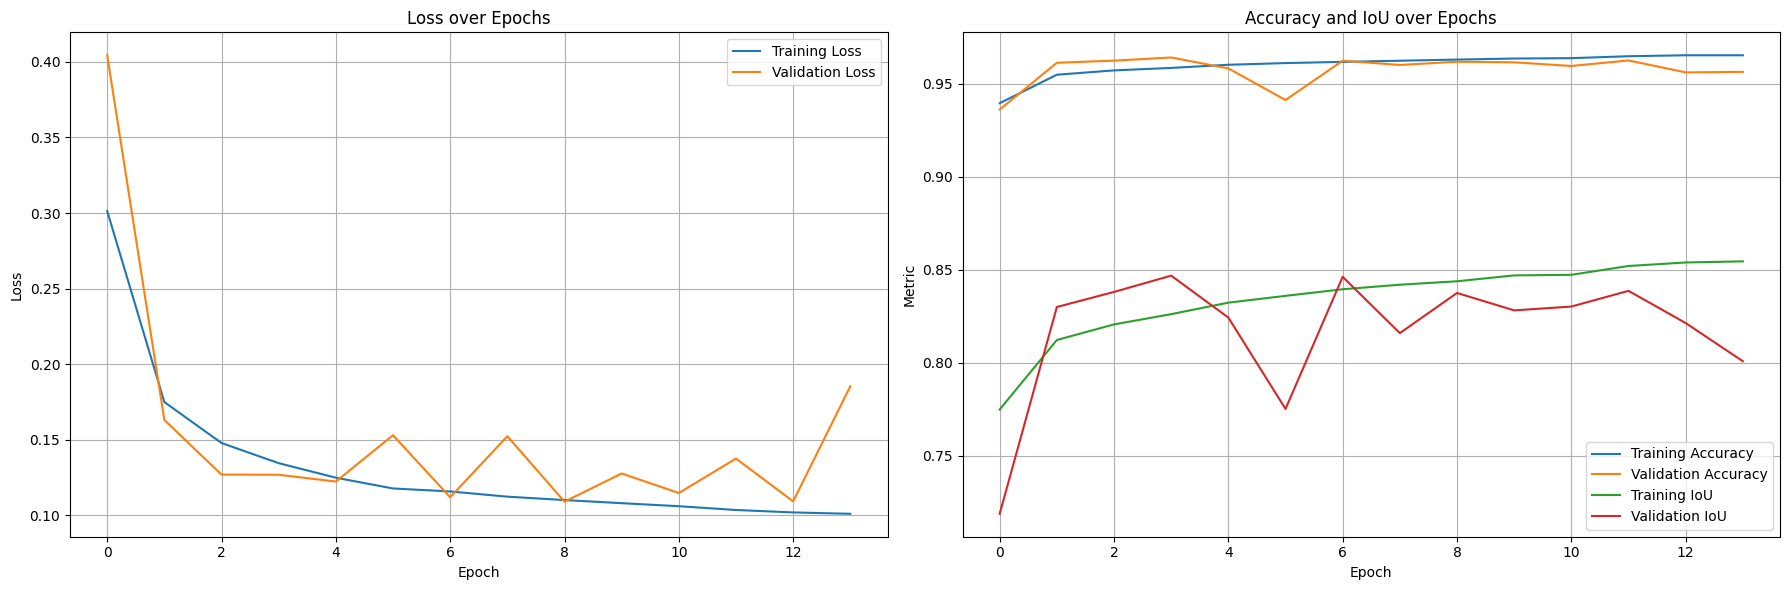

Learning rate history not available.


In [12]:
# CELL 11: Plot Training History for Double U-Net Model

import matplotlib.pyplot as plt

# Check available keys in history.history
print("Available keys in history.history:")
print(history.history.keys())

# Define the metrics you want to plot
metrics_to_plot = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'iou_metric', 'val_iou_metric']

plt.figure(figsize=(18, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy and IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Accuracy and IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Plot Learning Rate
if 'lr' in history.history:
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Learning rate history not available.")


In [13]:
# CELL 12: Compute IoU on Validation Set

from sklearn.metrics import accuracy_score, jaccard_score
import numpy as np

# Predict on validation data
val_predictions = model.predict(X_val)  # Shape: (N, 512, 128, 4)

# Convert predictions to class labels
val_predictions_labels = np.argmax(val_predictions, axis=-1)  # Shape: (N, 512, 128)
Y_val_labels = np.argmax(Y_val, axis=-1)                      # Shape: (N, 512, 128)

# Flatten the arrays
val_predictions_flat = val_predictions_labels.flatten()        # Shape: (N * 512 * 128,)
Y_val_flat = Y_val_labels.flatten()                            # Shape: (N * 512 * 128,)

# Ensure both flattened arrays have the same length
assert val_predictions_flat.shape == Y_val_flat.shape, "Shape mismatch between predictions and ground truth."

# Compute metrics
accuracy = accuracy_score(Y_val_flat, val_predictions_flat)
iou_score = jaccard_score(Y_val_flat, val_predictions_flat, average='macro')

print("Validation Accuracy:", accuracy)
print("Validation IoU Score:", iou_score)


17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Validation Accuracy: 0.9617105154656369
Validation IoU Score: 0.645858834814317


In [14]:
# CELL 13
# WORKING CODE
# Predict on test data
test_predictions = model.predict(X_test)

# Convert predictions to class labels
test_predictions_labels = np.argmax(test_predictions, axis=-1)  # Shape: (N_test, 512, 128)
Y_test_labels = np.argmax(Y_test, axis=-1)                      # Shape: (N_test, 512, 128)

# THIS CODE IS CHANGEABLE
# EXPERIMENTAL CODE
# CELL 13


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [15]:
# CELL 14: Compute IoU on Test Set

from sklearn.metrics import accuracy_score, jaccard_score, classification_report, confusion_matrix
import numpy as np

# Predict on test data
test_predictions = model.predict(X_test)  # Shape: (N_test, 512, 128, 4)

# Convert predictions to class labels
test_predictions_labels = np.argmax(test_predictions, axis=-1)  # Shape: (N_test, 512, 128)
Y_test_labels = np.argmax(Y_test, axis=-1)                      # Shape: (N_test, 512, 128)

# Flatten the arrays
test_predictions_flat = test_predictions_labels.flatten()        # Shape: (N_test * 512 * 128,)
Y_test_flat = Y_test_labels.flatten()                            # Shape: (N_test * 512 * 128,)

# Ensure both flattened arrays have the same length
assert test_predictions_flat.shape == Y_test_flat.shape, "Shape mismatch between predictions and ground truth."

# Compute metrics
accuracy = accuracy_score(Y_test_flat, test_predictions_flat)
iou_score = jaccard_score(Y_test_flat, test_predictions_flat, average='macro')
print("Test Accuracy:", accuracy)
print("Test IoU Score:", iou_score)

# Compute IoU for each class
class_iou_scores = jaccard_score(Y_test_flat, test_predictions_flat, average=None)
class_labels = np.unique(Y_test_flat)
for class_id, iou in zip(class_labels, class_iou_scores):
    print(f"IoU for class {class_id}: {iou}")

# Classification Report
report = classification_report(Y_test_flat, test_predictions_flat, labels=class_labels)
print("\nClassification Report:\n", report)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step
Test Accuracy: 0.9628349017771438
Test IoU Score: 0.6478767789123235
IoU for class 0: 0.9548224582611186
IoU for class 1: 0.8366631537214176
IoU for class 2: 0.1521447247544343

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98  15392458
           1       0.86      0.96      0.91   3797014
           2       0.58      0.17      0.26     12576

    accuracy                           0.96  19202048
   macro avg       0.81      0.70      0.72  19202048
weighted avg       0.97      0.96      0.96  19202048



In [16]:
# CELL 14B: Save the Double U-Net Model After Evaluation

import os
import shutil
from tensorflow.keras.models import load_model

# Define checkpoint directory
checkpoint_dir = '/kaggle/working/'

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the entire model in HDF5 format
model.save(os.path.join(checkpoint_dir, 'double_unet_final_model.h5'))
print("Model saved successfully as 'double_unet_final_model.h5'.")

# Optionally, compress the model
# shutil.make_archive(os.path.join(checkpoint_dir, 'double_unet_final_model'), 'zip', checkpoint_dir, 'double_unet_final_model.h5')
# print("Compressed 'double_unet_final_model.zip' created.")


Model saved successfully as 'double_unet_final_model.h5'.


In [17]:
# CELL 15

def convert_mask_to_rgb(mask):
    if len(mask.shape) > 2:
        mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    rgb_mask[mask == 0] = [0, 0, 0]        # Background (Black)
    # rgb_mask[mask == 1] = [128, 128, 128]  # Bone (Gray) [Commented out as per your original code]
    rgb_mask[mask == 2] = [0, 0, 255]      # Cancer Hotspot (Red in BGR)
    rgb_mask[mask == 3] = [0, 255, 0]      # Non-cancer (Green)
    return rgb_mask

# THIS IS CHANGEABLE
# EXPERIMENTAL CODE
# CELL 15


In [18]:
# CELL 16
# Specify the exact filenames you want to load
target_files = ['20.jpg', '32.jpg', '61.jpg', '75.jpg', '111.jpg', '139.jpg']

# Initialize lists to hold images and masks
images = []
masks = []
loaded_filenames = []  # To keep track of loaded filenames

# Load only specified images and their corresponding masks
for file in target_files:
    # Load and resize image
    image_path = os.path.join(image_dir, file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {file}, skipping.")
        continue
    # Resize image: cv2.resize expects (width, height)
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0  # Normalize image

    # Construct mask filename
    base_filename = os.path.splitext(file)[0]
    mask_filename = base_filename + '_colored_mask.npy'
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask not found for image {file}, skipping.")
        continue

    # Load and resize mask
    mask = np.load(mask_path)
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

    # Convert mask to one-hot encoding
    mask_one_hot = np.zeros((img_height, img_width, num_classes), dtype=np.uint8)
    for i in range(num_classes):
        mask_one_hot[..., i] = (mask == i).astype(np.uint8)

    images.append(image)
    masks.append(mask_one_hot)
    loaded_filenames.append(file)  # Keep track of the filename

# Convert lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)
print("Loaded filenames:", loaded_filenames)  # List of loaded filenames to confirm


Images shape: (6, 512, 128, 3)
Masks shape: (6, 512, 128, 4)
Loaded filenames: ['20.jpg', '32.jpg', '61.jpg', '75.jpg', '111.jpg', '139.jpg']


Loading best weights from: /kaggle/working/double_unet_best.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Unique labels in predicted mask for 20.jpg: [0 1 2]


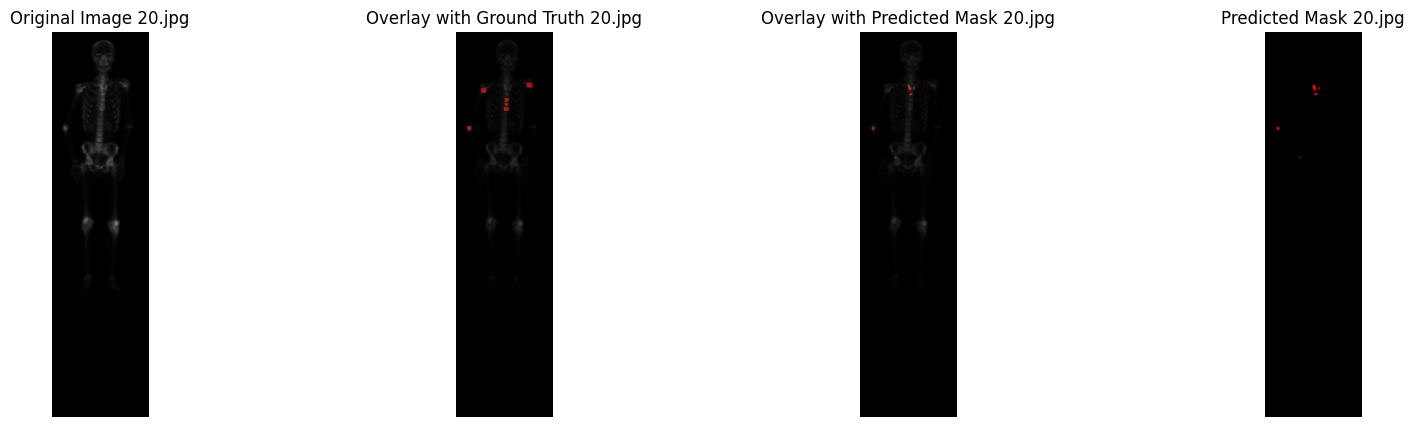

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 32.jpg: [0 1 2]


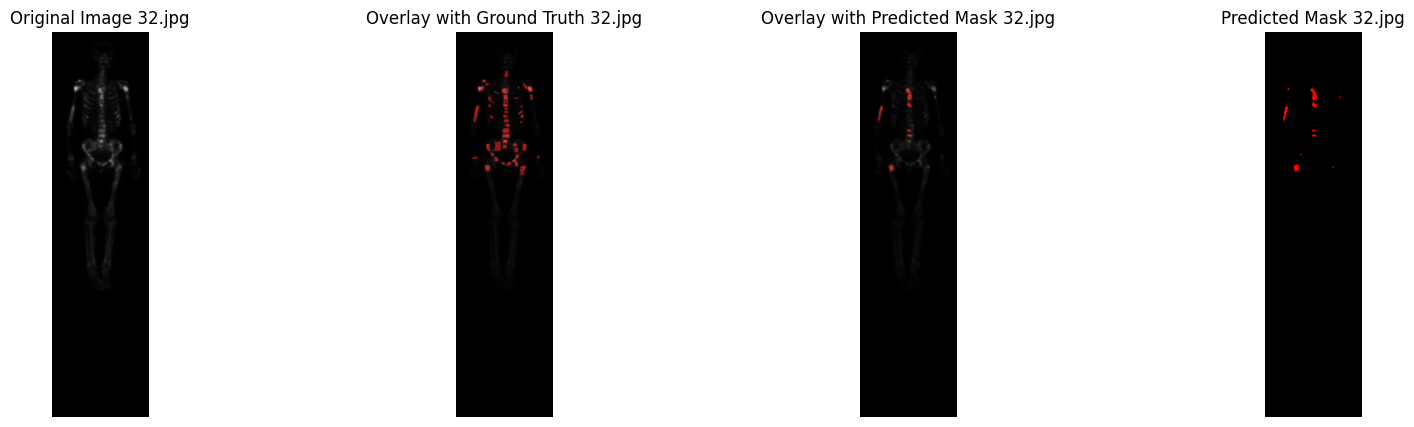

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 61.jpg: [0 1 2]


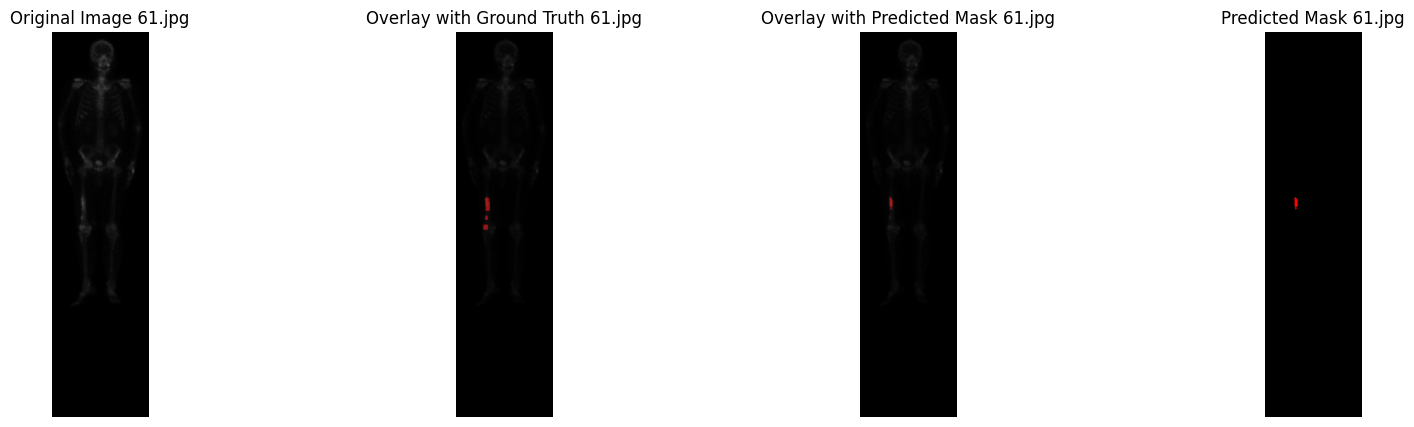

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 75.jpg: [0 1 2]


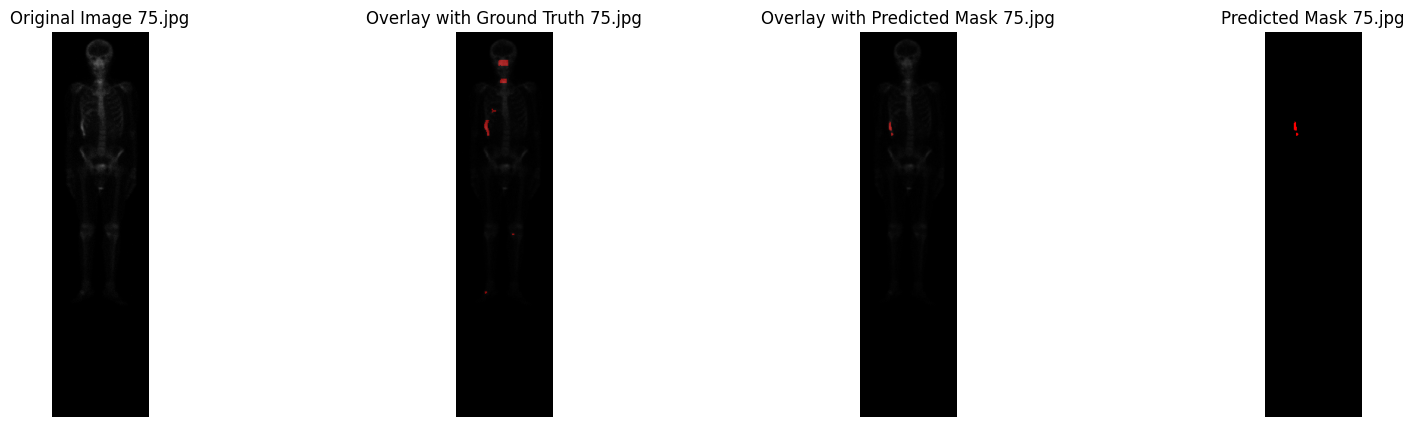

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 111.jpg: [0 1 2]


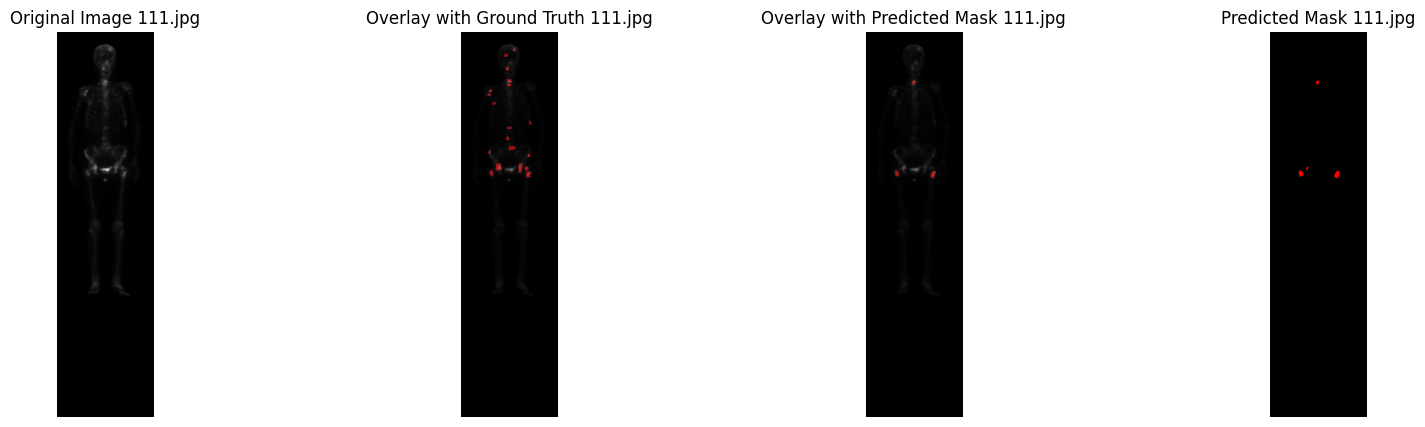

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 139.jpg: [0 1]


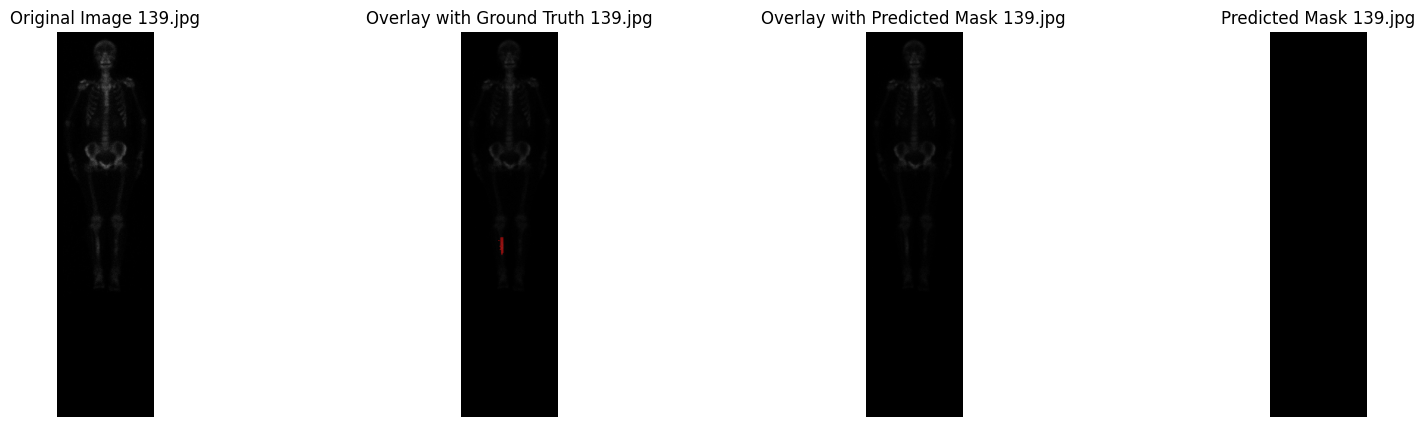

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 143.jpg: [0 1 2]


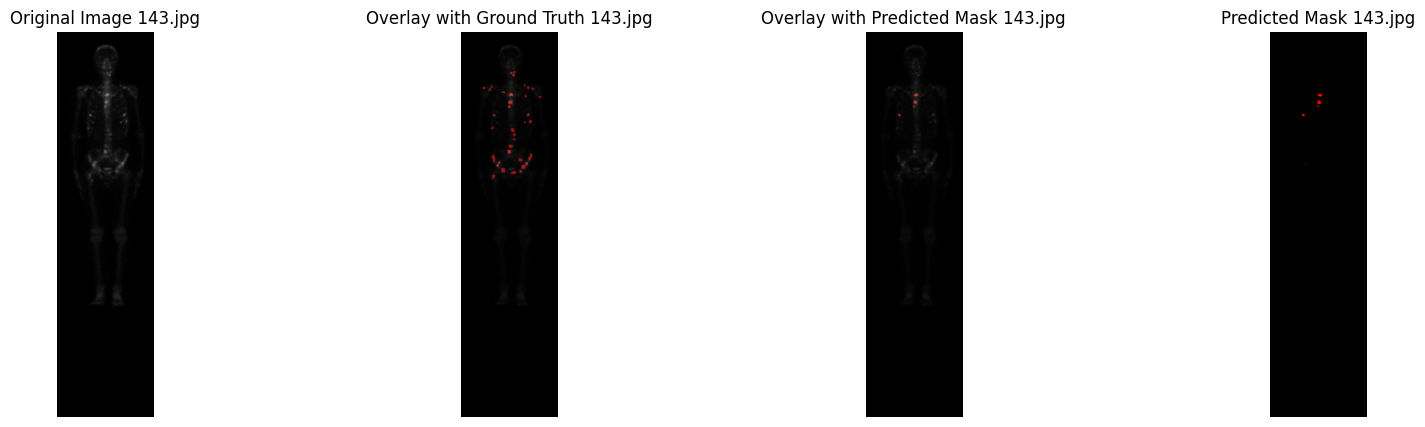

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 158.jpg: [0 1 2]


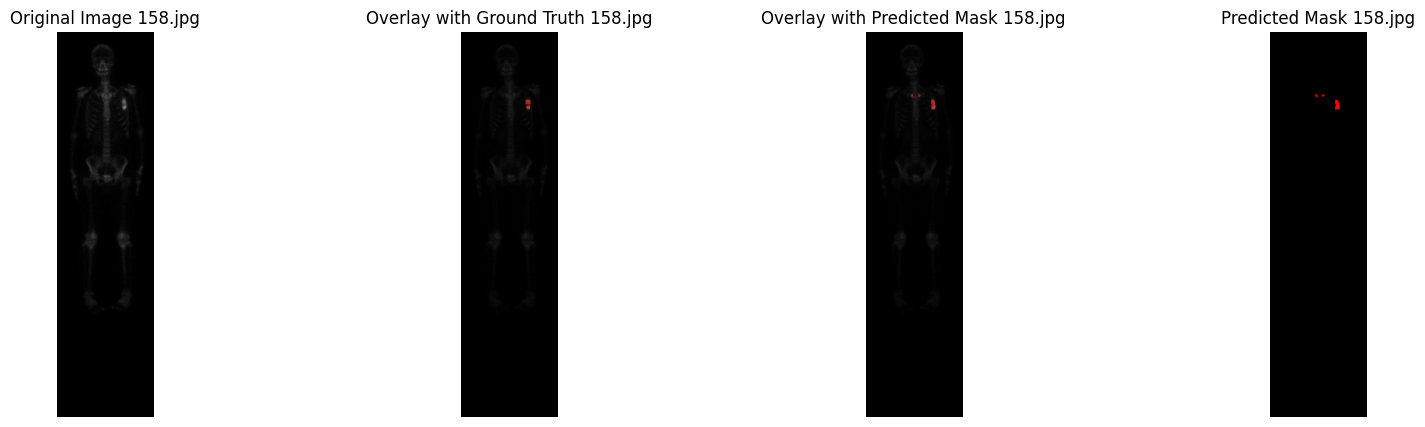

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 177.jpg: [0 1 2]


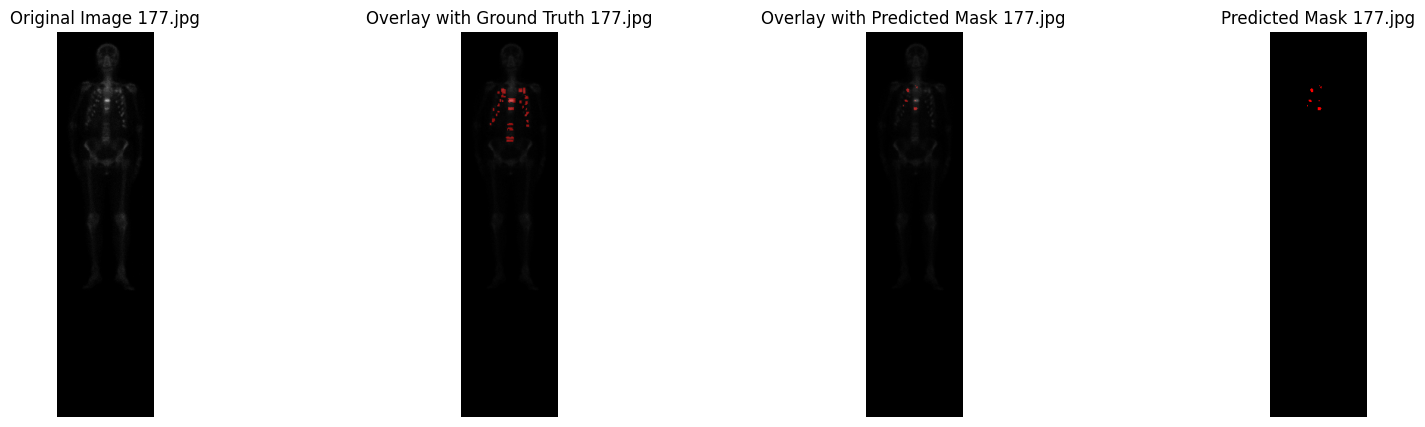

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 182.jpg: [0 1 2]


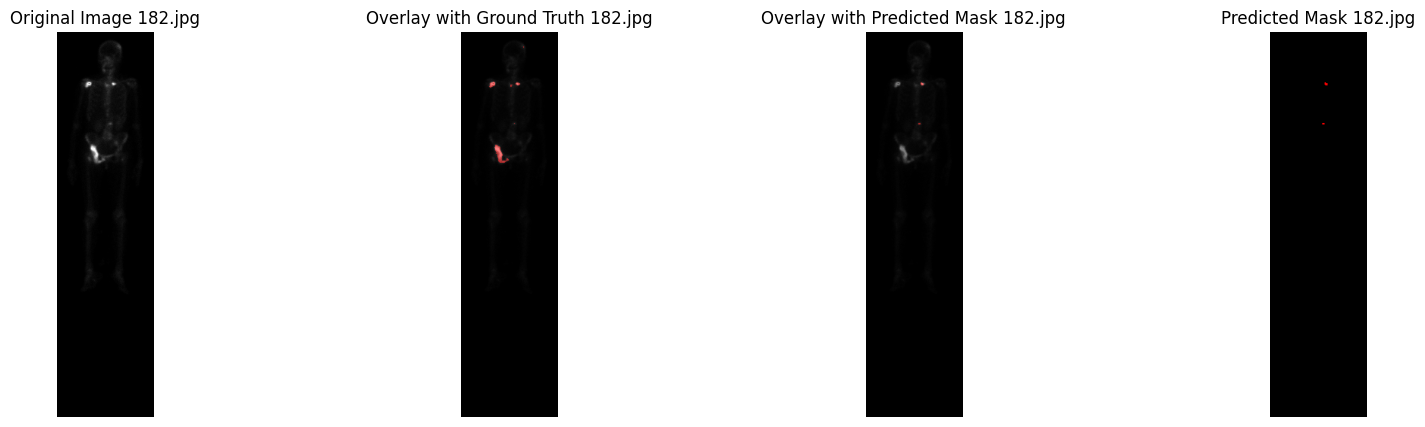

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 283.jpg: [0 1 2]


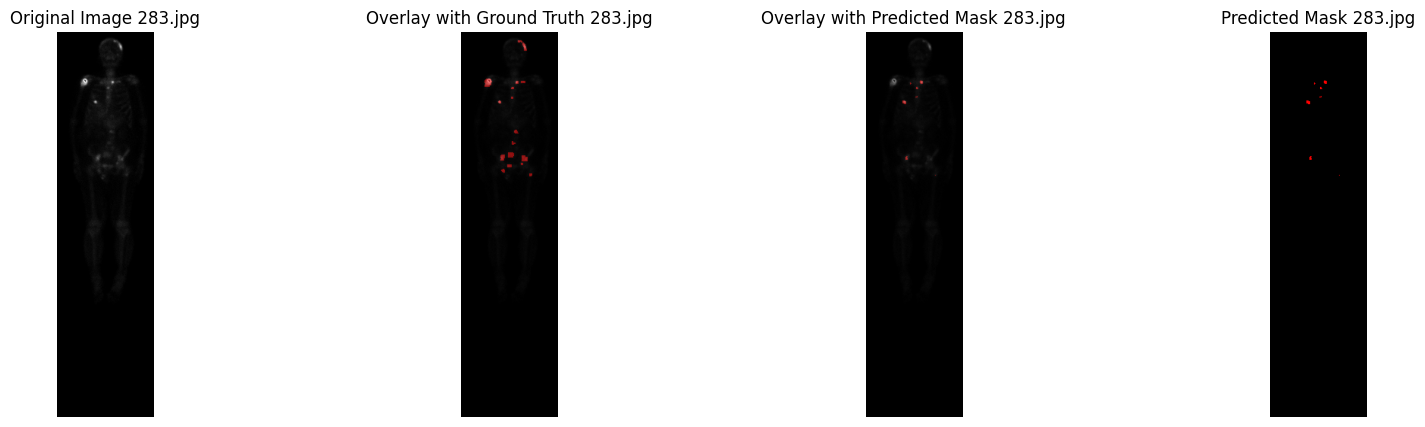

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Unique labels in predicted mask for 301.jpg: [0 1 2]


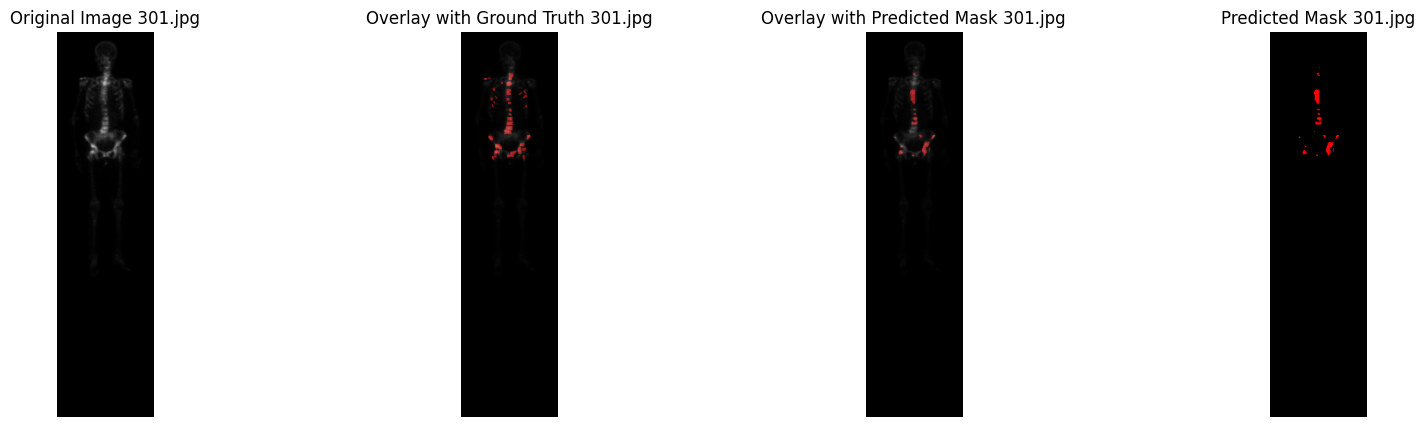

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Unique labels in predicted mask for 318.jpg: [0 1]


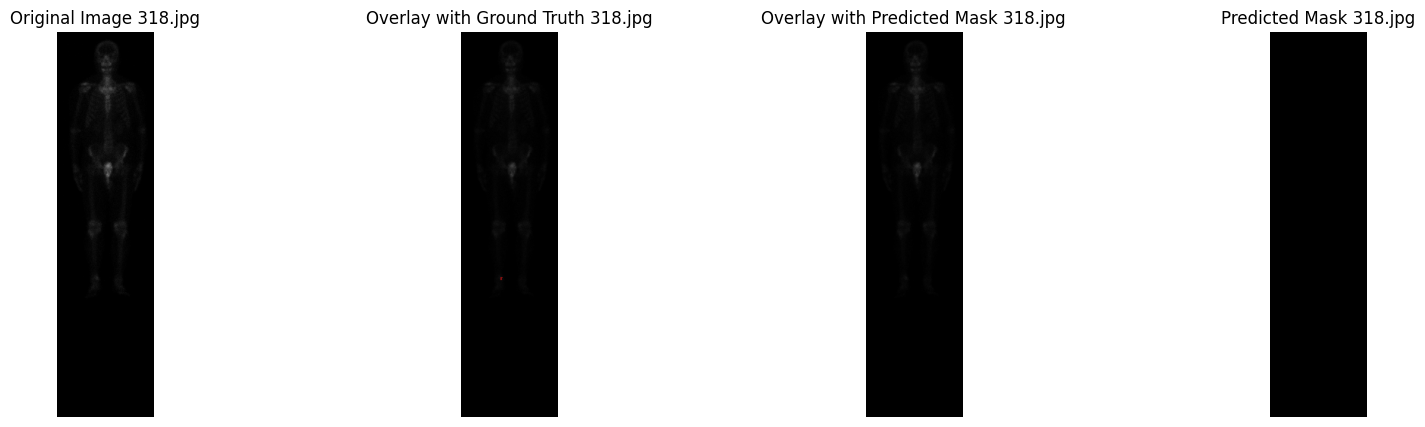

In [19]:
# CELL 17: Visualize Predictions and Ground Truth Masks

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random

# List of filenames to test
filenames = ["20.jpg", "32.jpg", "61.jpg", "75.jpg", "111.jpg", "139.jpg", "143.jpg", "158.jpg", "177.jpg", "182.jpg", "283.jpg", "301.jpg", "318.jpg"]

def overlay_mask(image, mask_rgb, alpha=0.5):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    if mask_rgb.dtype != np.uint8:
        mask_rgb = mask_rgb.astype(np.uint8)
    
    # Ensure both have 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if len(mask_rgb.shape) == 2:
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_GRAY2BGR)

    # Ensure the shapes match
    if image.shape != mask_rgb.shape:
        height, width = image.shape[:2]
        mask_rgb = cv2.resize(mask_rgb, (width, height), interpolation=cv2.INTER_NEAREST)
    
    overlay = cv2.addWeighted(mask_rgb, alpha, image, 1 - alpha, 0)
    return overlay

def convert_mask_to_rgb(mask):
    if len(mask.shape) > 2:
        mask = np.argmax(mask, axis=-1)
    if len(mask.shape) == 2:
        rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        rgb_mask[mask == 0] = [0, 0, 0]          # Background (Black)
        # rgb_mask[mask == 1] = [128, 128, 128]  # Bone (Gray) [Commented out as per your original code]
        rgb_mask[mask == 2] = [0, 0, 255]        # Cancer Hotspot (Red in BGR)
        rgb_mask[mask == 3] = [0, 255, 0]        # Non-cancer (Green)
        return rgb_mask
    else:
        raise ValueError("Mask must be a 2D array after processing.")

def display_image(image, title):
    """
    Converts an image from BGR to RGB and displays it using Matplotlib.
    
    Parameters:
    - image: The image to display (in BGR format).
    - title: The title of the plot.
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')

# Load the best weights
weights_file = os.path.join(checkpoint_dir, "double_unet_best.weights.h5")
if os.path.exists(weights_file):
    print("Loading best weights from:", weights_file)
    model.load_weights(weights_file)
else:
    print("No weights files found. Please check your checkpoint directory.")

# Predict and display results
for filename in filenames:
    # Load image in color mode
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Image {filename} not found, skipping.")
        continue

    # Resize and normalize image
    image_resized = cv2.resize(image, (img_width, img_height))
    image_normalized = image_resized / 255.0  # Normalize for prediction

    # Load ground truth mask
    mask_filename = filename.split('.')[0] + '_colored_mask.npy'
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(mask_path):
        print(f"Mask for {filename} not found, skipping.")
        continue
    mask = np.load(mask_path)
    
    # Process ground truth mask
    if len(mask.shape) > 2:
        mask = np.argmax(mask, axis=-1)  # Convert one-hot to class labels if necessary
    mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)  # Shape: (512, 128)

    # Convert ground truth mask to RGB and create overlay
    try:
        mask_rgb_gt = convert_mask_to_rgb(mask)  # Shape: (512, 128, 3)
    except ValueError as e:
        print(f"Error processing ground truth mask for {filename}: {e}, skipping.")
        continue

    overlay_gt = overlay_mask(image_resized, mask_rgb_gt, alpha=0.5)
    if overlay_gt is None:
        print(f"Error creating overlay for ground truth of {filename}, skipping.")
        continue

    # Perform prediction
    predictions = model.predict(image_normalized[np.newaxis, ...])  # Add batch dimension, Shape: (1, 512, 128, 4)

    # Extract the final output prediction without incorrect indexing
    pred_mask_probs = predictions[0]  # Shape: (512, 128, 4)
    pred_mask = np.argmax(pred_mask_probs, axis=-1)  # Shape: (512, 128)
    print(f"Unique labels in predicted mask for {filename}:", np.unique(pred_mask))

    # Convert predicted mask to RGB and create overlay
    try:
        mask_rgb_pred = convert_mask_to_rgb(pred_mask)  # Shape: (512, 128, 3)
    except ValueError as e:
        print(f"Error processing predicted mask for {filename}: {e}, skipping.")
        continue

    overlay_pred = overlay_mask(image_resized, mask_rgb_pred, alpha=0.5)
    if overlay_pred is None:
        print(f"Error creating overlay for prediction of {filename}, skipping.")
        continue

    # Plot the results
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    display_image(image_resized, f'Original Image {filename}')

    plt.subplot(1, 4, 2)
    display_image(overlay_gt, f'Overlay with Ground Truth {filename}')

    plt.subplot(1, 4, 3)
    display_image(overlay_pred, f'Overlay with Predicted Mask {filename}')

    plt.subplot(1, 4, 4)
    display_image(mask_rgb_pred, f'Predicted Mask {filename}')

    plt.show()


In [20]:
# CELL 18: Load and Compile the Double U-Net Model with Custom Loss and Metrics

from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

# Define class weights (ensure these match those used during training)
class_weights = np.array([1.0, 3.0, 5.0, 5.0])  # Adjust as per your training

# Define Focal Loss
def focal_loss(y_true, y_pred, gamma=2., alpha=class_weights):
    """
    Focal loss for multi-class classification.
    
    Parameters:
    - y_true: Ground truth one-hot encoded labels.
    - y_pred: Predicted probabilities.
    - gamma: Focusing parameter.
    - alpha: Class weights.
    
    Returns:
    - Computed focal loss.
    """
    alpha_tensor = K.constant(alpha, dtype=tf.float32)
    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * K.log(y_pred)
    weight = alpha_tensor * K.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return K.sum(loss, axis=-1)

# Define Dice Loss
def dice_loss(y_true, y_pred):
    """
    Dice loss for multi-class classification.
    
    Parameters:
    - y_true: Ground truth one-hot encoded labels.
    - y_pred: Predicted probabilities.
    
    Returns:
    - Computed dice loss.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1e-6
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Combined Loss
def combined_loss(y_true, y_pred):
    """
    Combined focal and dice loss.
    
    Parameters:
    - y_true: Ground truth one-hot encoded labels.
    - y_pred: Predicted probabilities.
    
    Returns:
    - Computed combined loss.
    """
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

# Define IoU Metric
def iou_metric(y_true, y_pred):
    """
    Intersection over Union (IoU) metric.
    
    Parameters:
    - y_true: Ground truth one-hot encoded labels.
    - y_pred: Predicted probabilities.
    
    Returns:
    - Computed IoU.
    """
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)
    intersection = K.sum(K.cast(y_true * y_pred, 'float32'))
    union = K.sum(K.cast(y_true + y_pred, 'float32')) - intersection
    return intersection / (union + K.epsilon())

# Define custom objects for model loading
custom_objects = {
    'combined_loss': combined_loss,
    'iou_metric': iou_metric,
    'conv_block': conv_block,
    'encoder_block': encoder_block,
    'decoder_block': decoder_block,
    'DoubleUNet': DoubleUNet
}

# Path to the saved model
model_path = '/kaggle/working/double_unet_final_model.h5'

# Load the model without compiling
model = load_model(model_path, custom_objects=custom_objects, compile=False)
print(f"Model successfully loaded from {model_path}")

# Define the optimizer (ensure it matches the one used during training)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Adjust as needed

# Compile the model with the custom loss and metric
model.compile(
    optimizer=optimizer,
    loss=combined_loss,          # Refactored combined loss
    metrics=[iou_metric]         # Custom IoU metric
)
print("Model successfully compiled with custom loss and metrics.")


Model successfully loaded from /kaggle/working/double_unet_final_model.h5
Model successfully compiled with custom loss and metrics.


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 662ms/step
Test Accuracy: 0.9628349017771438


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean IoU Score: 0.4859075841842426


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IoU for class 0: 0.9548224582611186
IoU for class 1: 0.8366631537214176
IoU for class 2: 0.1521447247544343
IoU for class 3: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98  15392458
           1       0.86      0.96      0.91   3797014
           2       0.58      0.17      0.26     12576
           3       0.00      0.00      0.00         0

   micro avg       0.96      0.96      0.96  19202048
   macro avg       0.61      0.52      0.54  19202048
weighted avg       0.97      0.96      0.96  19202048



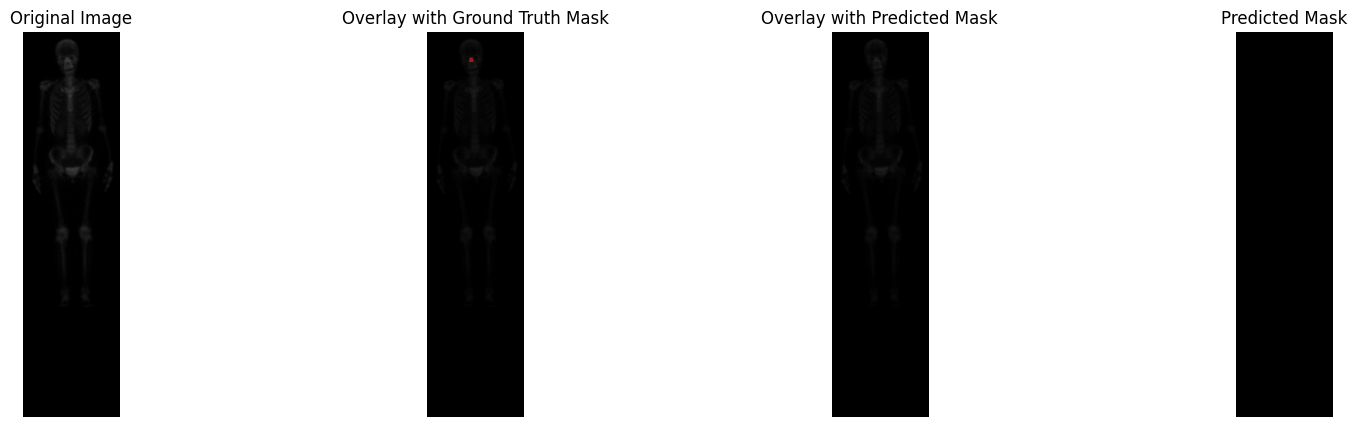

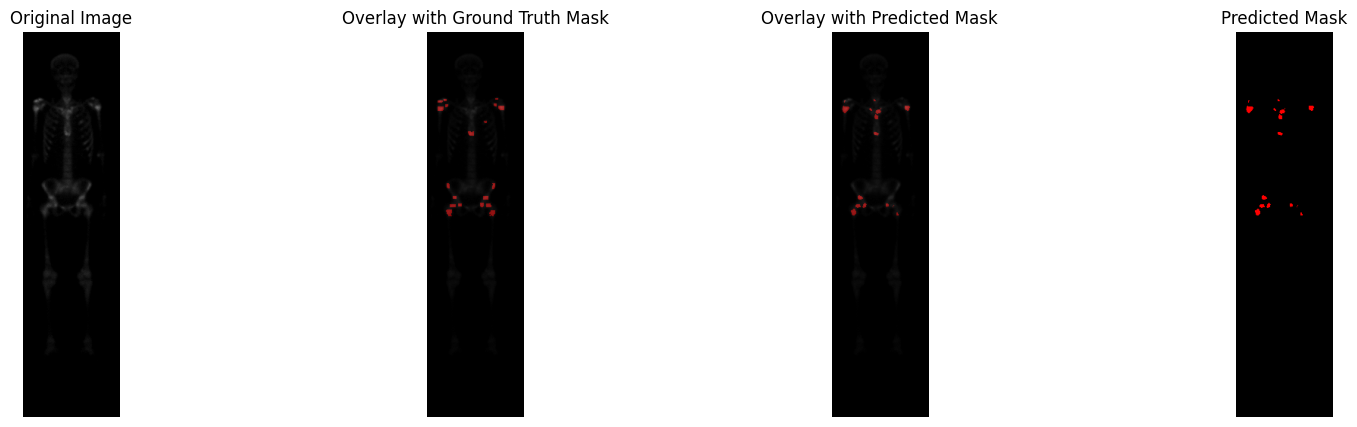

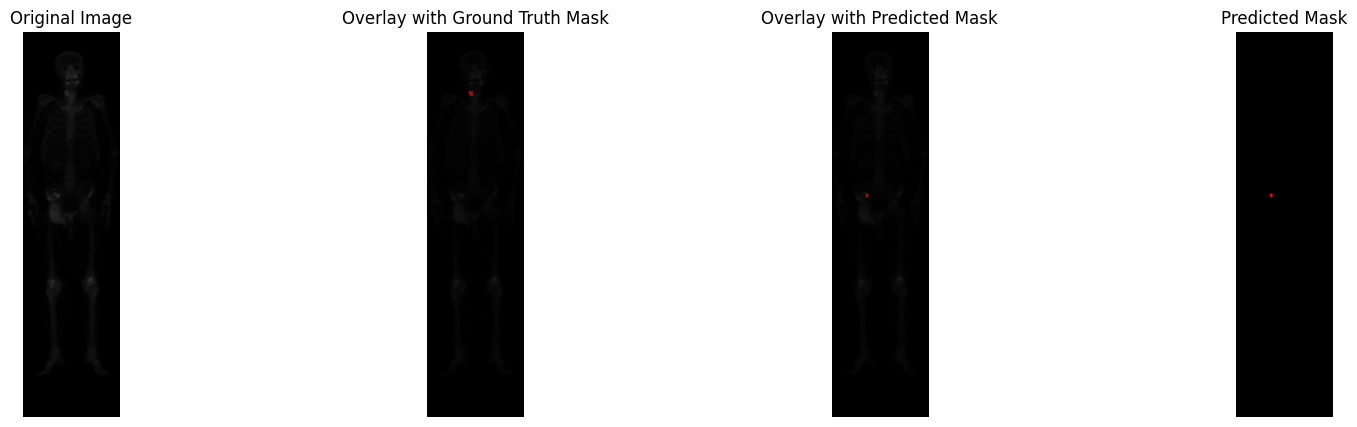

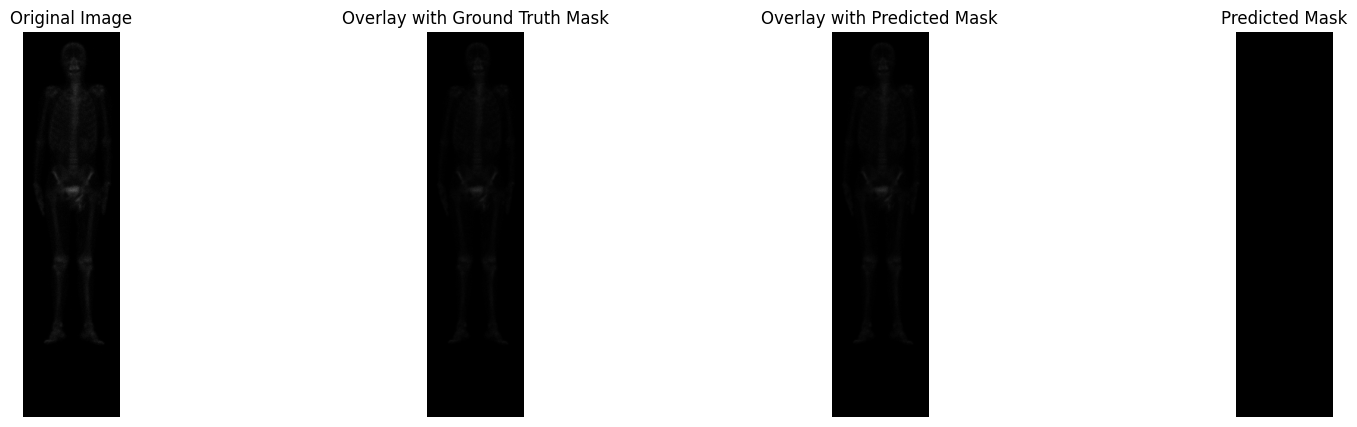

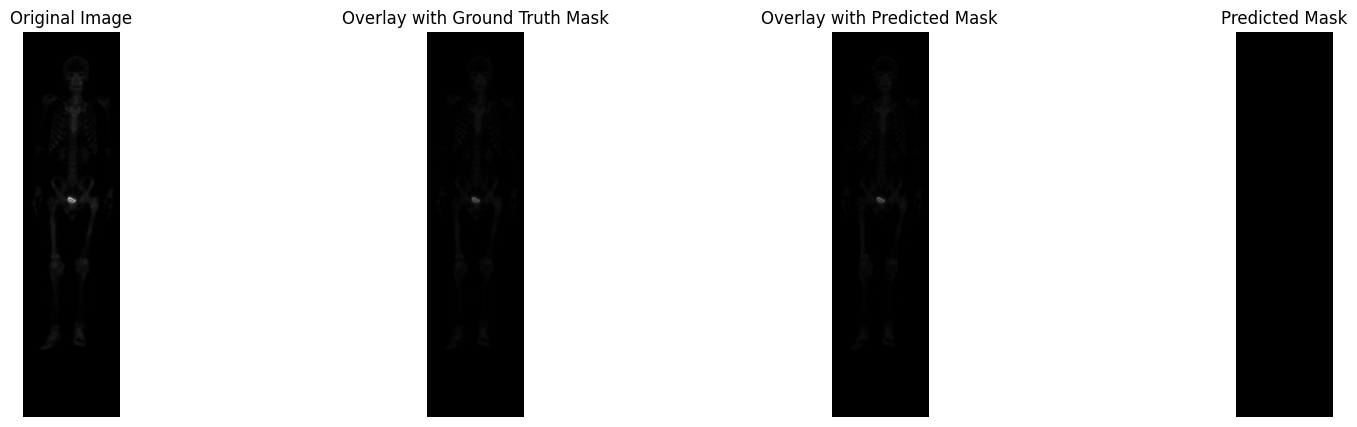

In [21]:
# CELL 19: Compute Metrics on Test Set

from sklearn.metrics import accuracy_score, jaccard_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import random

# Ensure that 'convert_mask_to_rgb' and 'display_image' functions are defined
# If not, include their definitions here or import them appropriately

# Predict on test data
test_predictions = model.predict(X_test)  # Shape: (N_test, 512, 128, 4)

# Convert predictions to class labels for all test samples
test_predictions_labels = np.argmax(test_predictions, axis=-1)  # Shape: (N_test, 512, 128)

# Convert ground truth masks to class labels
Y_test_labels = np.argmax(Y_test, axis=-1)  # Shape: (N_test, 512, 128)

# Flatten the arrays for metric computation
test_predictions_flat = test_predictions_labels.flatten()  # Shape: (N_test * 512 * 128,)
Y_test_flat = Y_test_labels.flatten()                      # Shape: (N_test * 512 * 128,)

# Ensure both flattened arrays have the same length
assert test_predictions_flat.shape == Y_test_flat.shape, "Shape mismatch between predictions and ground truth."

# Define class labels
class_labels = [0, 1, 2, 3]

# Compute Accuracy
accuracy = accuracy_score(Y_test_flat, test_predictions_flat)
print("Test Accuracy:", accuracy)

# Compute Mean IoU
iou_score = jaccard_score(Y_test_flat, test_predictions_flat, average='macro', labels=class_labels)
print("Mean IoU Score:", iou_score)

# Compute IoU for each class
class_iou_scores = jaccard_score(Y_test_flat, test_predictions_flat, average=None, labels=class_labels)
for class_id, iou in zip(class_labels, class_iou_scores):
    print(f"IoU for class {class_id}: {iou}")

# Classification Report
report = classification_report(Y_test_flat, test_predictions_flat, labels=class_labels)
print("\nClassification Report:\n", report)

# Optionally, display some test images with their predicted masks
num_samples = 5  # Number of test samples to display
indices = random.sample(range(len(X_test)), num_samples)

for idx in indices:
    image = X_test[idx]
    true_mask = Y_test_labels[idx]
    pred_mask = test_predictions_labels[idx]
    
    # Convert masks to RGB
    true_mask_rgb = convert_mask_to_rgb(true_mask)
    pred_mask_rgb = convert_mask_to_rgb(pred_mask)
    
    # Original image (rescale for display if necessary)
    image_disp = (image * 255).astype(np.uint8)
    
    # Overlays
    overlay_true = overlay_mask(image_disp, true_mask_rgb, alpha=0.5)
    overlay_pred = overlay_mask(image_disp, pred_mask_rgb, alpha=0.5)
    
    # Plot the results
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    display_image(image_disp, 'Original Image')
    
    plt.subplot(1, 4, 2)
    display_image(overlay_true, 'Overlay with Ground Truth Mask')
    
    plt.subplot(1, 4, 3)
    display_image(overlay_pred, 'Overlay with Predicted Mask')
    
    plt.subplot(1, 4, 4)
    display_image(pred_mask_rgb, 'Predicted Mask')
    
    plt.show()
